# 04 — Resilience via Latent Clustering for H₂ Valley
_Generated: 2025-11-04T23:26:27_

Este notebook implementa un **pipeline reproducible** para:
1) Cargar variables históricas y SSP (245/370/585)
2) Escalar con un **único scaler fit en histórico**
3) Entrenar un **autoencoder** (histórico)
4) Proyectar escenarios al **mismo espacio latente**
5) **Clusterizar** en z_hist y medir **resiliencia** entre escenarios
6) Generar tablas y gráficos base para análisis y paper

**Tip:** Rellena las rutas en la sección 1. Correr todo en orden.

## 0) Setup
- Importaciones
- Semillas
- Config (paths y parámetros)

In [5]:
import os
import numpy as np
import pandas as pd
import xarray as xr

import torch
import torch.nn as nn

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

# Reproducibilidad
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Configuración de paths (💡 AJUSTA ESTO)
BASE_DIR = "/home/aninotna/magister/tesis/justh2_pipeline"
DATA_DIR = os.path.join(BASE_DIR, "data/autoencoder_tensors")

# ============================================================================
# RUTAS DE DATOS PREPROCESADOS
# ============================================================================
# Estos archivos fueron generados por: 
# scripts/idroverdi_autoencoder/02_preprocess_for_autoencoder.ipynb
# 
# Contienen:
# - X_train, X_val, X_test: arrays (n_samples, n_features)
# - idx_train, idx_val, idx_test: índices espaciales
# ============================================================================

MODE = "test"  # Coincide con el usado en preprocesamiento

# DATOS NORMALIZADOS (para entrenar autoencoder)
PATH_SSP245 = os.path.join(DATA_DIR, f"tensors_ssp245_splits_{MODE}.npz")
PATH_SSP370 = os.path.join(DATA_DIR, f"tensors_ssp370_splits_{MODE}.npz")
PATH_SSP585 = os.path.join(DATA_DIR, f"tensors_ssp585_splits_{MODE}.npz")

# DATOS ORIGINALES (para cálculos de H2 y visualizaciones)
PATH_SSP245_ORIG = os.path.join(DATA_DIR, f"tensors_ssp245_splits_{MODE}_ORIGINAL.npz")
PATH_SSP370_ORIG = os.path.join(DATA_DIR, f"tensors_ssp370_splits_{MODE}_ORIGINAL.npz")
PATH_SSP585_ORIG = os.path.join(DATA_DIR, f"tensors_ssp585_splits_{MODE}_ORIGINAL.npz")

# Metadatos y nombres de variables
PATH_METADATA = os.path.join(DATA_DIR, f"metadata_{MODE}.pkl")
PATH_FEATURE_NAMES = os.path.join(DATA_DIR, f"feature_names_{MODE}.csv")
PATH_SCALERS = os.path.join(DATA_DIR, f"scalers_{MODE}.pkl")

# ============================================================================
# NOTA IMPORTANTE: 
# - Para HISTÓRICO, usaremos SSP245 como referencia (período más cercano)
# - Las variables temporales ya vienen agregadas por década (2020-2100)
# - Total de features: ~303 (variables climáticas × décadas + variables estáticas)
# ============================================================================

# Variables candidatas (ajusta según tu preprocessing real)
# ESTAS VARIABLES YA ESTÁN INCLUIDAS EN LOS TENSORES PREPROCESADOS
VARS_SELECTED = [
    # clima medio (por década)
    "tmax_mean", "tmin_mean", "prcptot",
    # extremos (ETCCDI) por década
    "r10mm", "rx1day", "rx5day", "cdd", "sdii",
    # energía / producción (estáticas o por década según tu setup)
    "calliope_cf_mean",
    "calliope_h2_prod_ton",
    # geografía (estáticas)
    "topo_elevation", 
    "topo_slope",
    # uso de suelo / restricciones (estáticas)
    "landuse_suitable_pv", "landuse_restricted",
    "landuse_agriculture", "landuse_urban_infra",
    "landuse_water_glacier",
    # riesgo socioambiental (estáticas)
    "conflict_density", 
    "conflict_proximity",
]

# Parámetros del AE y clustering
LATENT_DIM = 8
EPOCHS = 200
LR = 1e-3
N_CLUSTERS = 6   # Ajustar con silhouette si quieres

print("✓ Configuración cargada")
print(f"✓ Base dir: {BASE_DIR}")
print(f"✓ Data dir: {DATA_DIR}")
print(f"✓ Mode: {MODE}")


✓ Configuración cargada
✓ Base dir: /home/aninotna/magister/tesis/justh2_pipeline
✓ Data dir: /home/aninotna/magister/tesis/justh2_pipeline/data/autoencoder_tensors
✓ Mode: test


## 1) Cargar datasets
Soporta `.parquet`/`.csv`/`.npy`. Ajusta rutas arriba.
- Requiere mismas columnas en cada escenario.
- Debe incluir `calliope_h2_prod_ton` para métricas operacionales.

In [9]:
# ============================================================================
# CARGAR DATOS PREPROCESADOS (.npz)
# ============================================================================

def load_npz_data(path, is_original=False):
    """
    Carga archivo .npz y combina train/val/test en un solo array.
    
    Args:
        path: ruta al archivo .npz
        is_original: True si es archivo ORIGINAL (usa sufijos _original)
    
    Returns:
        np.ndarray: (n_samples, n_features)
    """
    data = np.load(path)
    
    if is_original:
        # Archivos ORIGINAL usan sufijo _original
        X = np.vstack([
            data['X_train_original'],
            data['X_val_original'],
            data['X_test_original']
        ])
    else:
        # Archivos normalizados usan nombres estándar
        X = np.vstack([
            data['X_train'],
            data['X_val'],
            data['X_test']
        ])
    
    return X

# Cargar datos NORMALIZADOS (para autoencoder)
print("Cargando datos normalizados...")
X_ssp245_norm = load_npz_data(PATH_SSP245, is_original=False)
X_ssp370_norm = load_npz_data(PATH_SSP370, is_original=False)
X_ssp585_norm = load_npz_data(PATH_SSP585, is_original=False)

# Cargar datos ORIGINALES (para métricas de H2)
print("Cargando datos originales...")
X_ssp245_orig = load_npz_data(PATH_SSP245_ORIG, is_original=True)
X_ssp370_orig = load_npz_data(PATH_SSP370_ORIG, is_original=True)
X_ssp585_orig = load_npz_data(PATH_SSP585_ORIG, is_original=True)

# Cargar nombres de features
feature_names_df = pd.read_csv(PATH_FEATURE_NAMES)
feature_names = feature_names_df['feature_name'].tolist()

print("\n" + "="*80)
print("DATOS CARGADOS")
print("="*80)
print(f"SSP245 (norm): {X_ssp245_norm.shape}")
print(f"SSP370 (norm): {X_ssp370_norm.shape}")
print(f"SSP585 (norm): {X_ssp585_norm.shape}")
print(f"SSP245 (orig): {X_ssp245_orig.shape}")
print(f"SSP370 (orig): {X_ssp370_orig.shape}")
print(f"SSP585 (orig): {X_ssp585_orig.shape}")
print(f"\nTotal features: {len(feature_names)}")
print(f"Samples por escenario: {X_ssp245_norm.shape[0]}")

# Mostrar primeras features
print("\nPrimeras 10 features:")
for i, name in enumerate(feature_names[:10]):
    print(f"  {i:3d}. {name}")

# ============================================================================
# IMPORTANTE: USAREMOS SSP245 COMO "HISTÓRICO" DE REFERENCIA
# ============================================================================
# Dado que no tenemos datos históricos separados, usamos SSP245 (escenario 
# más cercano a la tendencia histórica) como baseline para comparar cambios
# en los otros escenarios.
# ============================================================================

X_hist_df = pd.DataFrame(X_ssp245_norm, columns=feature_names)
X_ssp245_df = pd.DataFrame(X_ssp245_norm, columns=feature_names)
X_ssp370_df = pd.DataFrame(X_ssp370_norm, columns=feature_names)
X_ssp585_df = pd.DataFrame(X_ssp585_norm, columns=feature_names)

# DataFrames originales (para H2)
X_hist_orig_df = pd.DataFrame(X_ssp245_orig, columns=feature_names)
X_ssp245_orig_df = pd.DataFrame(X_ssp245_orig, columns=feature_names)
X_ssp370_orig_df = pd.DataFrame(X_ssp370_orig, columns=feature_names)
X_ssp585_orig_df = pd.DataFrame(X_ssp585_orig, columns=feature_names)

print("\n✓ DataFrames creados (normalizados y originales)")


Cargando datos normalizados...
Cargando datos originales...

DATOS CARGADOS
SSP245 (norm): (661, 293)
SSP370 (norm): (661, 293)
SSP585 (norm): (661, 293)
SSP245 (orig): (661, 293)
SSP370 (orig): (661, 293)
SSP585 (orig): (661, 293)

Total features: 293
Samples por escenario: 661

Primeras 10 features:
    0. calliope_h2_prod_ton
    1. calliope_lcoh_usd_kg
    2. calliope_cap_electrolyzer_mw
    3. calliope_cf_mean
    4. topo_slope
    5. topo_elevation
    6. landuse_suitable_pv
    7. landuse_restricted
    8. landuse_agriculture
    9. landuse_urban_infra

✓ DataFrames creados (normalizados y originales)


In [10]:
# Verificar que los datos están cargados correctamente
print("VERIFICACIÓN DE DATOS CARGADOS")
print("="*80)
print(f"PATH_SSP245: {PATH_SSP245}")
print(f"Archivo existe: {os.path.exists(PATH_SSP245)}")
print(f"\nVariables en memoria:")
print(f"  X_ssp245_norm: {X_ssp245_norm.shape if 'X_ssp245_norm' in dir() else 'NO EXISTE'}")
print(f"  X_ssp370_norm: {X_ssp370_norm.shape if 'X_ssp370_norm' in dir() else 'NO EXISTE'}")
print(f"  X_ssp585_norm: {X_ssp585_norm.shape if 'X_ssp585_norm' in dir() else 'NO EXISTE'}")
print(f"  feature_names: {len(feature_names) if 'feature_names' in dir() else 'NO EXISTE'}")


VERIFICACIÓN DE DATOS CARGADOS
PATH_SSP245: /home/aninotna/magister/tesis/justh2_pipeline/data/autoencoder_tensors/tensors_ssp245_splits_test.npz
Archivo existe: True

Variables en memoria:
  X_ssp245_norm: (661, 293)
  X_ssp370_norm: (661, 293)
  X_ssp585_norm: (661, 293)
  feature_names: 293


In [29]:
import re

# Define tu baseline y décadas objetivo
BASE_DECADES   = [2020]          # referencia (sin histórico explícito)
TARGET_DECADES = [2040, 2060, 2080]  # futuro

def cols_for_decades(feature_names, decades):
    """Devuelve columnas decenales que terminan en _decadal_(mean|max|min)_YYYY para YYYY ∈ decades."""
    pat = re.compile(r"_decadal_(?:mean|max|min|std)_(\d{4})$")
    keep_idx, keep_names = [], []
    for j, name in enumerate(feature_names):
        m = pat.search(name)
        if m and int(m.group(1)) in decades:
            keep_idx.append(j); keep_names.append(name)
    return keep_idx, keep_names

def non_decadal_cols(feature_names):
    idx = [j for j, n in enumerate(feature_names) if "_decadal_" not in n]
    names = [feature_names[j] for j in idx]
    return idx, names

base_idx, base_cols   = cols_for_decades(feature_names, BASE_DECADES)
tgt_idx,  tgt_cols    = cols_for_decades(feature_names, TARGET_DECADES)
non_idx,  non_cols    = non_decadal_cols(feature_names)

print(f"Base decadal cols: {len(base_cols)} | Target decadal cols: {len(tgt_cols)} | Non-decadal: {len(non_cols)}")

# ============================================================================
# ESTRATEGIA: USAR LAS MISMAS FEATURES PARA BASELINE Y TARGET
# ============================================================================
# Para que el autoencoder funcione, necesitamos la misma dimensionalidad.
# 
# Opción 1: Usar SOLO variables no-decenales (estáticas)
# Opción 2: Usar BASE_DECADE para todos (baseline y target usan 2020)
# Opción 3: Agregar variables climáticas promediando décadas target
# 
# Implementaremos Opción 1 (más simple) y Opción 3 (más informativa)
# ============================================================================

# OPCIÓN 1: Solo variables no-decenales (estáticas)
def subset_norm(X_norm, take_idx):
    return X_norm[:, take_idx]

# Usando SOLO variables estáticas
BASE_245_static = subset_norm(X_ssp245_norm, non_idx)
BASE_370_static = subset_norm(X_ssp370_norm, non_idx)
BASE_585_static = subset_norm(X_ssp585_norm, non_idx)

T245_static = subset_norm(X_ssp245_norm, non_idx)  # Mismas estáticas
T370_static = subset_norm(X_ssp370_norm, non_idx)
T585_static = subset_norm(X_ssp585_norm, non_idx)

# OPCIÓN 3: Agregar estadísticas de décadas target (mean de las 3 décadas)
# Extraer datos de target decades y promediar
def get_decadal_mean(X_norm, tgt_idx, n_decades):
    """Promedia features decenales agrupadas por variable base."""
    X_tgt = X_norm[:, tgt_idx]
    n_samples = X_tgt.shape[0]
    n_vars_per_decade = len(tgt_idx) // n_decades
    
    # Reshape y promediar
    X_reshaped = X_tgt.reshape(n_samples, n_decades, n_vars_per_decade)
    X_mean = X_reshaped.mean(axis=1)  # Promedio sobre décadas
    
    return X_mean

# Calcular mean de target decades
T245_climate = get_decadal_mean(X_ssp245_norm, tgt_idx, len(TARGET_DECADES))
T370_climate = get_decadal_mean(X_ssp370_norm, tgt_idx, len(TARGET_DECADES))
T585_climate = get_decadal_mean(X_ssp585_norm, tgt_idx, len(TARGET_DECADES))

# Baseline climate (usar década 2020)
BASE_245_climate = subset_norm(X_ssp245_norm, base_idx)
BASE_370_climate = subset_norm(X_ssp370_norm, base_idx)
BASE_585_climate = subset_norm(X_ssp585_norm, base_idx)

# Combinar climate + estáticas
BASE_245 = np.hstack([BASE_245_climate, BASE_245_static])
BASE_370 = np.hstack([BASE_370_climate, BASE_370_static])
BASE_585 = np.hstack([BASE_585_climate, BASE_585_static])

T245 = np.hstack([T245_climate, T245_static])
T370 = np.hstack([T370_climate, T370_static])
T585 = np.hstack([T585_climate, T585_static])

# Baseline combinado para entrenar AE
X_BASE = np.vstack([BASE_245, BASE_370, BASE_585])

print("\n" + "="*80)
print("MATRICES CONSTRUIDAS (misma dimensionalidad)")
print("="*80)
print(f"BASE_245: {BASE_245.shape}")
print(f"BASE_370: {BASE_370.shape}")
print(f"BASE_585: {BASE_585.shape}")
print(f"T245:     {T245.shape}")
print(f"T370:     {T370.shape}")
print(f"T585:     {T585.shape}")
print(f"X_BASE (combinado): {X_BASE.shape}")
print(f"\n✓ Todas las matrices tienen {BASE_245.shape[1]} features")


Base decadal cols: 32 | Target decadal cols: 96 | Non-decadal: 13

MATRICES CONSTRUIDAS (misma dimensionalidad)
BASE_245: (661, 45)
BASE_370: (661, 45)
BASE_585: (661, 45)
T245:     (661, 45)
T370:     (661, 45)
T585:     (661, 45)
X_BASE (combinado): (1983, 45)

✓ Todas las matrices tienen 45 features


## 4) Autoencoder — entrenamiento en histórico
Arquitectura MLP simple (suficiente para vectores). Puedes cambiar a conv si usas grillas 2D.

In [30]:
# AE más robusto (BatchNorm + Dropout + LeakyReLU)
class AE(nn.Module):
    def __init__(self, input_dim, latent_dim=8, p_drop=0.1):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(p_drop),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(p_drop),
            nn.Linear(64, latent_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(128, input_dim),
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

# Split simple en baseline para early stopping
perm = np.random.permutation(X_BASE.shape[0])
n_val = int(0.2 * len(perm))
val_idx, tr_idx = perm[:n_val], perm[n_val:]
X_tr, X_val = X_BASE[tr_idx], X_BASE[val_idx]

def train_ae(model, X_tr, X_val, epochs=400, lr=1e-3, batch_size=64,
             weight_decay=1e-4, noise_std=0.05, patience=30, verbose=True):
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    Xtr = torch.tensor(X_tr, dtype=torch.float32)
    Xva = torch.tensor(X_val, dtype=torch.float32)
    best, best_val, wait = None, float("inf"), 0

    for ep in range(epochs):
        model.train()
        idx = torch.randperm(Xtr.size(0))
        for i in range(0, Xtr.size(0), batch_size):
            batch = Xtr[idx[i:i+batch_size]]
            noisy = batch + noise_std*torch.randn_like(batch)
            opt.zero_grad()
            x_hat, _ = model(noisy)
            loss = ((x_hat - batch)**2).mean()
            loss.backward()
            opt.step()

        model.eval()
        with torch.no_grad():
            xhat_val, _ = model(Xva)
            val_loss = ((xhat_val - Xva)**2).mean().item()

        if verbose and ep % 25 == 0:
            print(f"ep {ep:03d} | val_mse={val_loss:.6f}")

        if val_loss < best_val - 1e-6:
            best_val = val_loss
            best = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                if verbose: print(f"Early stop @ {ep} | best_val={best_val:.6f}")
                break

    if best is not None:
        model.load_state_dict(best)
    return model

input_dim = X_BASE.shape[1]
model = AE(input_dim, latent_dim=LATENT_DIM, p_drop=0.1)
model = train_ae(model, X_tr, X_val, epochs=400, lr=LR,
                 batch_size=64, weight_decay=1e-4, noise_std=0.05, patience=30)


ep 000 | val_mse=7.420811
ep 025 | val_mse=0.178158
ep 025 | val_mse=0.178158
ep 050 | val_mse=0.121548
ep 050 | val_mse=0.121548
ep 075 | val_mse=0.075298
ep 075 | val_mse=0.075298
ep 100 | val_mse=0.065730
ep 100 | val_mse=0.065730
ep 125 | val_mse=0.056648
ep 125 | val_mse=0.056648
ep 150 | val_mse=0.051546
ep 150 | val_mse=0.051546
ep 175 | val_mse=0.049279
ep 175 | val_mse=0.049279
ep 200 | val_mse=0.048776
ep 200 | val_mse=0.048776
ep 225 | val_mse=0.048958
ep 225 | val_mse=0.048958
ep 250 | val_mse=0.039572
ep 250 | val_mse=0.039572
ep 275 | val_mse=0.042214
ep 275 | val_mse=0.042214
ep 300 | val_mse=0.037262
ep 300 | val_mse=0.037262
ep 325 | val_mse=0.033556
ep 325 | val_mse=0.033556
ep 350 | val_mse=0.037172
ep 350 | val_mse=0.037172
Early stop @ 354 | best_val=0.031967
Early stop @ 354 | best_val=0.031967


## 5) Obtener embeddings (hist y SSPs)
Usamos **el mismo encoder** (pesos fijos).

In [31]:
@torch.no_grad()
def get_z(model, X):
    return model.encoder(torch.tensor(X, dtype=torch.float32)).numpy()

# Embeddings
z_base = get_z(model, X_BASE)
zB245  = get_z(model, BASE_245)
zB370  = get_z(model, BASE_370)
zB585  = get_z(model, BASE_585)
z_245  = get_z(model, T245)
z_370  = get_z(model, T370)
z_585  = get_z(model, T585)

# Clustering en baseline (sobre z_base)
ks = (4,5,6,7,8,10)
best_k, best_s = None, -1
for k in ks:
    km_tmp = KMeans(n_clusters=k, n_init=10, random_state=SEED).fit(z_base)
    sc = silhouette_score(z_base, km_tmp.labels_)
    if sc > best_s:
        best_k, best_s = k, sc

print(f"K óptimo aprox (silhouette): {best_k} | score ~ {best_s:.3f}")
km = KMeans(n_clusters=best_k if best_k else N_CLUSTERS, n_init=10, random_state=SEED).fit(z_base)

# Asignación de clúster por escenario (baseline vs target del mismo SSP)
clB_245 = km.predict(zB245); cl_245 = km.predict(z_245)
clB_370 = km.predict(zB370); cl_370 = km.predict(z_370)
clB_585 = km.predict(zB585); cl_585 = km.predict(z_585)


K óptimo aprox (silhouette): 5 | score ~ 0.357


In [32]:
# Distancia TARGET vs BASE alineado por fila (suponemos que el orden espacial es el mismo por escenario)
dist_245 = np.linalg.norm(z_245 - zB245, axis=1)
dist_370 = np.linalg.norm(z_370 - zB370, axis=1)
dist_585 = np.linalg.norm(z_585 - zB585, axis=1)

# Estabilidad de clúster (1 = permanece en el mismo cluster que su baseline)
stab_245 = (cl_245 == clB_245).astype(int)
stab_370 = (cl_370 == clB_370).astype(int)
stab_585 = (cl_585 == clB_585).astype(int)

print("Median dist:", np.median(dist_245), np.median(dist_370), np.median(dist_585))
print("Mean stability:", stab_245.mean(), stab_370.mean(), stab_585.mean())


Median dist: 4.414256 8.514453 6.4330983
Mean stability: 0.6081694402420574 0.0 0.5037821482602118


In [33]:
# Ayudante para detectar columnas de H2 (decenal o estática)
def get_h2_cols(names, decades):
    # prueba decenales
    pat = re.compile(r"calliope_h2_prod_ton_decadal_(?:mean|max|min)_(\d{4})$")
    pick_idx = []
    for j, n in enumerate(names):
        m = pat.search(n)
        if m and int(m.group(1)) in decades:
            pick_idx.append(j)
    if pick_idx: 
        return pick_idx, [names[j] for j in pick_idx]
    # fallback: columna estática
    if "calliope_h2_prod_ton" in names:
        j = names.index("calliope_h2_prod_ton")
        return [j], ["calliope_h2_prod_ton"]
    raise ValueError("No encuentro columnas de calliope_h2_prod_ton (decenales ni estática).")

# Indices de H2 en baseline (2020) y targets (2040/2060/2080)
h2_base_idx, _ = get_h2_cols(feature_names, BASE_DECADES)
h2_tgt_idx,  _ = get_h2_cols(feature_names, TARGET_DECADES)

def take_h2(X_orig, idxs):
    # Si hay más de una década target, tomamos promedio por fila
    H = X_orig[:, idxs]
    if H.ndim == 2 and H.shape[1] > 1:
        return H.mean(axis=1)
    return H.squeeze()

# OJO: usamos los ORIGINALES, no los normalizados
h2_B245 = take_h2(X_ssp245_orig, h2_base_idx)
h2_B370 = take_h2(X_ssp370_orig, h2_base_idx)
h2_B585 = take_h2(X_ssp585_orig, h2_base_idx)

h2_245 = take_h2(X_ssp245_orig, h2_tgt_idx)
h2_370 = take_h2(X_ssp370_orig, h2_tgt_idx)
h2_585 = take_h2(X_ssp585_orig, h2_tgt_idx)

eps = 1e-8 + (h2_B245==0)*1e-3
drop_245 = (h2_B245 - h2_245) / (h2_B245 + eps)
drop_370 = (h2_B370 - h2_370) / (h2_B370 + eps)
drop_585 = (h2_B585 - h2_585) / (h2_B585 + eps)

print("H2 mean base vs target:",
      (float(h2_B245.mean()), float(h2_245.mean())),
      (float(h2_B370.mean()), float(h2_370.mean())),
      (float(h2_B585.mean()), float(h2_585.mean())))


H2 mean base vs target: (5764.454329082357, 5764.454329082357) (5753.4894905032625, 5753.4894905032625) (5842.381022627884, 5842.381022627884)


              R_245         R_370         R_585
count  6.610000e+02  6.610000e+02  6.610000e+02
mean   6.330399e-09  5.962948e-08  1.618937e-07
std    5.103289e-01  3.335858e-01  3.851325e-01
min   -1.464956e+00 -8.433909e-01 -1.779325e+00
25%   -3.786746e-01 -2.556731e-01 -2.077083e-01
50%    7.108254e-02  9.187356e-02 -4.819126e-02
75%    3.984717e-01  2.867295e-01  2.826442e-01
max    8.621648e-01  4.779638e-01  7.621924e-01


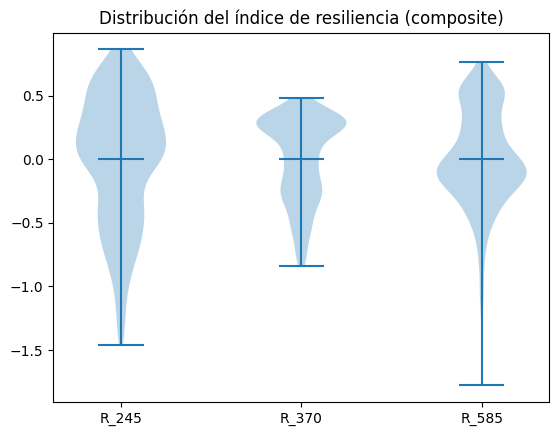

In [34]:
def zscore(x):
    x = np.asarray(x)
    return (x - np.nanmean(x)) / (np.nanstd(x) + 1e-9)

def composite_resilience(dist, stab, drop):
    # Queremos dist baja (invertir), stab alta, drop baja (invertir)
    return ( -zscore(dist) + zscore(stab) - zscore(drop) ) / 3.0

R_245 = composite_resilience(dist_245, stab_245, drop_245)
R_370 = composite_resilience(dist_370, stab_370, drop_370)
R_585 = composite_resilience(dist_585, stab_585, drop_585)

print(pd.DataFrame({"R_245":R_245, "R_370":R_370, "R_585":R_585}).describe())

plt.figure()
plt.violinplot([R_245, R_370, R_585], showmeans=True)
plt.xticks([1,2,3], ["R_245","R_370","R_585"])
plt.title("Distribución del índice de resiliencia (composite)")
plt.show()


In [35]:
import numpy as np
import pandas as pd
from scipy.stats import wilcoxon, spearmanr, kruskal

def summarize_components(dist, stab, drop, name):
    df = pd.DataFrame({
        "dist": dist, "stab": stab, "drop": drop,
        "R": ( - (dist - dist.mean())/ (dist.std()+1e-9)
              + (stab - stab.mean())/ (stab.std()+1e-9)
              - (drop - drop.mean())/ (drop.std()+1e-9) ) / 3.0
    })
    print(f"\n== {name} ==")
    print(df.describe()[["dist","stab","drop","R"]])
    rho_d, p_d = spearmanr(df["dist"], df["drop"])
    print(f"Spearman(dist, drop) = {rho_d:.3f} (p={p_d:.2e})")
    return df

df245 = summarize_components(dist_245, stab_245, drop_245, "SSP245")
df370 = summarize_components(dist_370, stab_370, drop_370, "SSP370")
df585 = summarize_components(dist_585, stab_585, drop_585, "SSP585")

# Tests de diferencias (pareados por píxel)
print("\n== Tests entre escenarios (Wilcoxon pareado, R) ==")
for a_name, a, b_name, b in [("245", R_245, "370", R_370),
                             ("245", R_245, "585", R_585),
                             ("370", R_370, "585", R_585)]:
    stat, p = wilcoxon(a, b, zero_method="wilcox", alternative="two-sided", correction=True)
    print(f"{a_name} vs {b_name}: W={stat}, p={p:.2e}")

# Global (no pareado) como referencia
H, p = kruskal(R_245, R_370, R_585)
print(f"\nKruskal-Wallis: H={H:.3f}, p={p:.2e}")



== SSP245 ==
             dist        stab   drop             R
count  661.000000  661.000000  661.0  6.610000e+02
mean     4.445840    0.608169    0.0  6.330399e-09
std      1.403047    0.488529    0.0  5.103289e-01
min      1.944943    0.000000    0.0 -1.464956e+00
25%      3.347901    0.000000    0.0 -3.786746e-01
50%      4.414256    1.000000    0.0  7.108254e-02
75%      5.319729    1.000000    0.0  3.984717e-01
max      8.860729    1.000000    0.0  8.621648e-01
Spearman(dist, drop) = nan (p=nan)

== SSP370 ==
             dist   stab   drop             R
count  661.000000  661.0  661.0  6.610000e+02
mean     9.029997    0.0    0.0  5.962948e-08
std      1.871900    0.0    0.0  3.335858e-01
min      6.347926    0.0    0.0 -8.433909e-01
25%      7.421029    0.0    0.0 -2.556731e-01
50%      8.514453    0.0    0.0  9.187356e-02
75%     10.464694    0.0    0.0  2.867295e-01
max     13.762644    0.0    0.0  4.779638e-01
Spearman(dist, drop) = nan (p=nan)

== SSP585 ==
             di

/tmp/ipykernel_1043458/3220003786.py:14: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho_d, p_d = spearmanr(df["dist"], df["drop"])
/tmp/ipykernel_1043458/3220003786.py:14: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho_d, p_d = spearmanr(df["dist"], df["drop"])
/tmp/ipykernel_1043458/3220003786.py:14: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho_d, p_d = spearmanr(df["dist"], df["drop"])


In [36]:
def composite_resilience_w(dist, stab, drop, w_d=1.0, w_s=1.0, w_h2=2.0):
    z = lambda x: (x - np.nanmean(x)) / (np.nanstd(x) + 1e-9)
    return ( -w_d*z(dist) + w_s*z(stab) - w_h2*z(drop) ) / (w_d + w_s + w_h2)

R_245_w = composite_resilience_w(dist_245, stab_245, drop_245, w_d=1, w_s=1, w_h2=2)
R_370_w = composite_resilience_w(dist_370, stab_370, drop_370, w_d=1, w_s=1, w_h2=2)
R_585_w = composite_resilience_w(dist_585, stab_585, drop_585, w_d=1, w_s=1, w_h2=2)


In [38]:
import pickle


# Cargar metadatos y ver qué contiene
with open(PATH_METADATA, "rb") as f:
    meta = pickle.load(f)

print("Claves disponibles en metadata:")
print(list(meta.keys()))
print("\nContenido del metadata:")
for k, v in meta.items():
    if isinstance(v, (list, np.ndarray, pd.DataFrame)):
        print(f"  {k}: {type(v).__name__} shape={getattr(v, 'shape', len(v))}")
    else:
        print(f"  {k}: {type(v).__name__} = {v}")

# Intentar construir coords_df desde los splits
# Los archivos .npz tienen train_idx, val_idx, test_idx
data_npz = np.load(PATH_SSP245)
print("\nClaves en .npz:")
print(list(data_npz.keys()))

# Combinar índices espaciales
if 'train_idx' in data_npz:
    all_idx = np.concatenate([
        data_npz['train_idx'],
        data_npz['val_idx'],
        data_npz['test_idx']
    ])
    print(f"\nÍndices espaciales combinados: {len(all_idx)} puntos")
    
    # Si hay spatial_mask en metadata
    if 'spatial_mask' in meta:
        mask = meta['spatial_mask']
        print(f"Spatial mask shape: {mask.shape}")
        
        # Obtener coordenadas lat/lon desde el dataset original
        # Cargar stack original para extraer coordenadas
        stack_path = "/home/aninotna/magister/tesis/justh2_pipeline/data/autoencoder_stack/autoencoder_stack_ssp245_test_imputed.nc"
        if os.path.exists(stack_path):
            ds = xr.open_dataset(stack_path)
            lats = ds['lat'].values
            lons = ds['lon'].values
            
            # Crear grid de coordenadas
            lat_grid, lon_grid = np.meshgrid(lats, lons, indexing='ij')
            
            # Flatten y filtrar por mask
            lat_flat = lat_grid[mask]
            lon_flat = lon_grid[mask]
            
            # Reordenar según all_idx
            lat_ordered = lat_flat[all_idx]
            lon_ordered = lon_flat[all_idx]
            
            coords_df = pd.DataFrame({
                'lat': lat_ordered,
                'lon': lon_ordered,
                'pixel_id': np.arange(len(all_idx))
            })
            
            print(f"\n✓ Coordenadas extraídas: {coords_df.shape}")
            print(coords_df.head())
            ds.close()
        else:
            print(f"\n⚠️ No se encontró {stack_path}")
            # Fallback: crear índices dummy
            coords_df = pd.DataFrame({
                'pixel_id': np.arange(len(all_idx)),
                'lat': np.nan,
                'lon': np.nan
            })
else:
    print("\n⚠️ No se encontraron índices espaciales en .npz")
    coords_df = None


Claves disponibles en metadata:
['feature_names', 'n_features', 'mask', 'mask_name', 'spatial_info', 'splits', 'n_cells', 'config', 'var_normalization', 'scenarios', 'reference_scenario', 'mode', 'created_at']

Contenido del metadata:
  feature_names: list shape=293
  n_features: int = 293
  mask: ndarray shape=(24, 42)
  mask_name: str = h2v_viable
  spatial_info: dict = {'lat': array([-33.325, -33.275, -33.225, -33.175, -33.125, -33.075, -33.025,
       -32.975, -32.925, -32.875, -32.825, -32.775, -32.725, -32.675,
       -32.625, -32.575, -32.525, -32.475, -32.425, -32.375, -32.325,
       -32.275, -32.225, -32.175]), 'lon': array([-71.975, -71.925, -71.875, -71.825, -71.775, -71.725, -71.675,
       -71.625, -71.575, -71.525, -71.475, -71.425, -71.375, -71.325,
       -71.275, -71.225, -71.175, -71.125, -71.075, -71.025, -70.975,
       -70.925, -70.875, -70.825, -70.775, -70.725, -70.675, -70.625,
       -70.575, -70.525, -70.475, -70.425, -70.375, -70.325, -70.275,
       -70.225

In [39]:
# Extraer info espacial
lat = meta["spatial_info"]["lat"]
lon = meta["spatial_info"]["lon"]
grid_shape = meta["spatial_info"]["grid_shape"]  # (24, 42)
mask = meta["mask"]  # celdas viables

# Crear grilla completa
lat_grid, lon_grid = np.meshgrid(lat, lon, indexing="ij")

# Flatten y aplicar máscara espacial (solo píxeles viables)
lat_flat = lat_grid[mask]
lon_flat = lon_grid[mask]

# Reconstruir el orden de los datos según train+val+test indices
splits = meta["splits"]
all_idx = np.concatenate([splits["train_idx"], splits["val_idx"], splits["test_idx"]])

lat_ordered = lat_flat[all_idx]
lon_ordered = lon_flat[all_idx]

coords_df = pd.DataFrame({
    "lat": lat_ordered,
    "lon": lon_ordered,
    "pixel_id": np.arange(len(lat_ordered))
})

print("✓ Coordenadas reconstruidas:", coords_df.shape)
coords_df.head()


✓ Coordenadas reconstruidas: (661, 3)


,lat,lon,pixel_id
0,-32.975,-70.025,0
1,-32.875,-71.025,1
2,-32.275,-70.575,2
3,-32.825,-70.875,3
4,-32.525,-70.175,4


In [40]:
res_df = pd.DataFrame({
    "lat": coords_df["lat"],
    "lon": coords_df["lon"],
    "R_245": R_245,
    "R_370": R_370,
    "R_585": R_585,
})
res_df.head()


,lat,lon,R_245,R_370,R_585
0,-32.975,-70.025,0.255647,0.389018,-0.656916
1,-32.875,-71.025,0.398472,0.027050,0.573082
2,-32.275,-70.575,-1.025879,0.261823,-0.038747
3,-32.825,-70.875,0.620964,0.131933,0.479745
4,-32.525,-70.175,-0.181863,0.366078,-0.238667


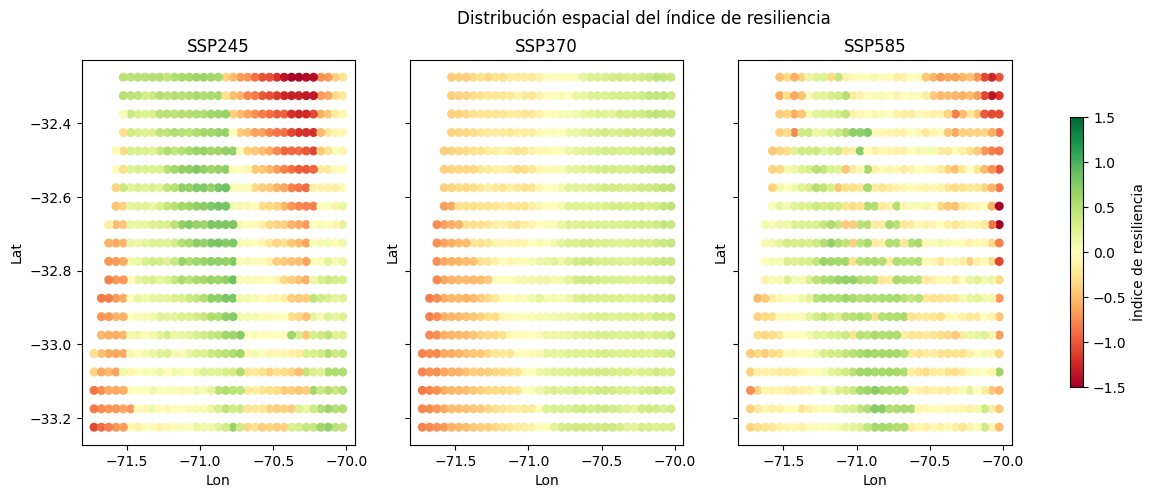

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(15,5), sharex=True, sharey=True)
titles = ["SSP245", "SSP370", "SSP585"]
cols = ["R_245", "R_370", "R_585"]

for ax, col, title in zip(axes, cols, titles):
    sc = ax.scatter(res_df["lon"], res_df["lat"], c=res_df[col],
                    cmap="RdYlGn", s=30, vmin=-1.5, vmax=1.5)
    ax.set_title(title)
    ax.set_xlabel("Lon")
    ax.set_ylabel("Lat")

fig.colorbar(sc, ax=axes, shrink=0.7, label="Índice de resiliencia")
plt.suptitle("Distribución espacial del índice de resiliencia")
plt.show()


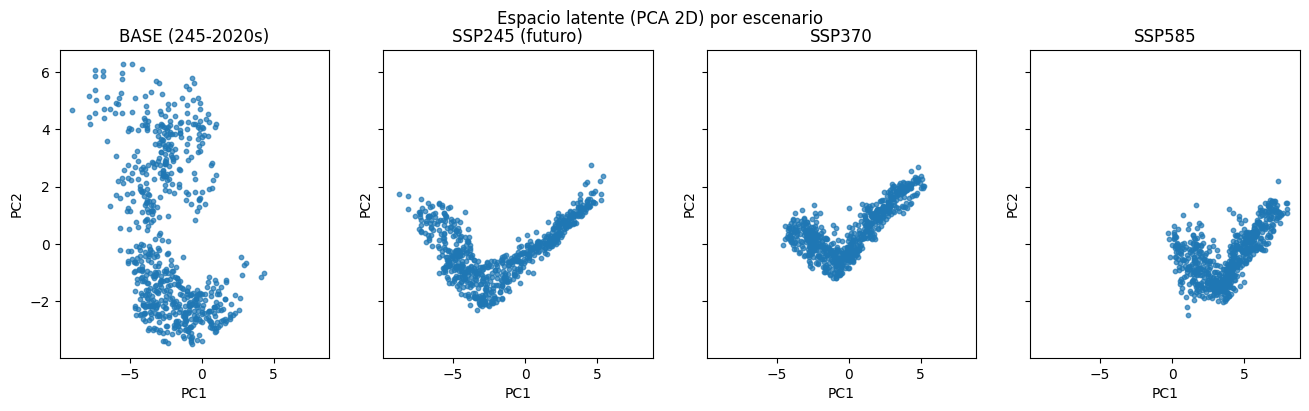

In [42]:
from sklearn.decomposition import PCA

# 2D común para comparar escenarios en el MISMO sistema de ejes
Z_all = np.vstack([zB245, z_245, z_370, z_585])
pca = PCA(n_components=2, random_state=SEED).fit(Z_all)

ZB245_2d = pca.transform(zB245)
Z245_2d  = pca.transform(z_245)
Z370_2d  = pca.transform(z_370)
Z585_2d  = pca.transform(z_585)

fig, axes = plt.subplots(1, 4, figsize=(16,4), sharex=True, sharey=True)
titles = ["BASE (245-2020s)", "SSP245 (futuro)", "SSP370", "SSP585"]
for ax, Z2d, ttl in zip(axes, [ZB245_2d, Z245_2d, Z370_2d, Z585_2d], titles):
    ax.scatter(Z2d[:,0], Z2d[:,1], s=10, alpha=0.7)
    ax.set_title(ttl)
    ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
plt.suptitle("Espacio latente (PCA 2D) por escenario")
plt.show()


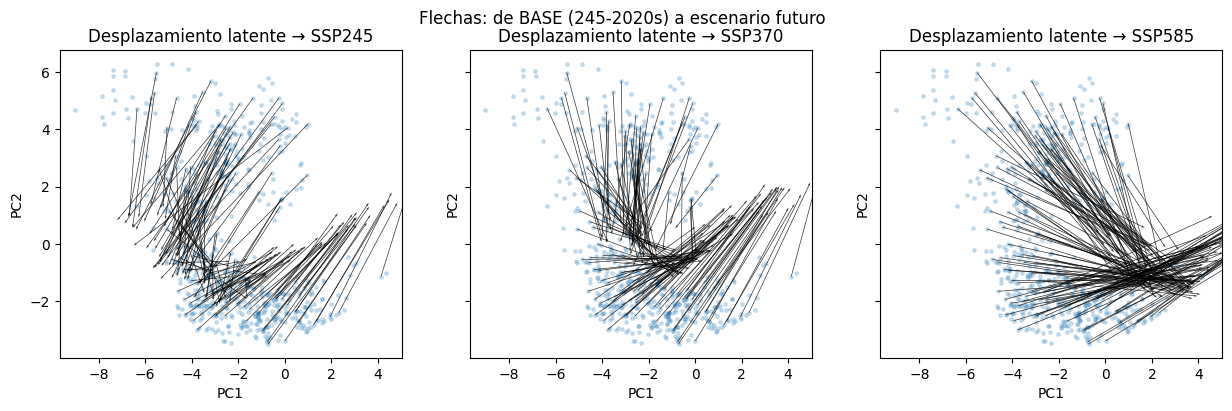

In [43]:
# Muestra aleatoria para no saturar
rng = np.random.default_rng(SEED)
idx = rng.choice(ZB245_2d.shape[0], size=min(150, ZB245_2d.shape[0]), replace=False)

fig, axes = plt.subplots(1, 3, figsize=(15,4), sharex=True, sharey=True)
for ax, Zf_2d, name in zip(axes, [Z245_2d, Z370_2d, Z585_2d], ["SSP245", "SSP370", "SSP585"]):
    ax.scatter(ZB245_2d[:,0], ZB245_2d[:,1], s=6, alpha=0.2)               # baseline nube
    ax.quiver(ZB245_2d[idx,0], ZB245_2d[idx,1],
              (Zf_2d-ZB245_2d)[idx,0], (Zf_2d-ZB245_2d)[idx,1],
              angles='xy', scale_units='xy', scale=1, width=0.002, alpha=0.8)
    ax.set_title(f"Desplazamiento latente → {name}")
    ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
plt.suptitle("Flechas: de BASE (245-2020s) a escenario futuro")
plt.show()


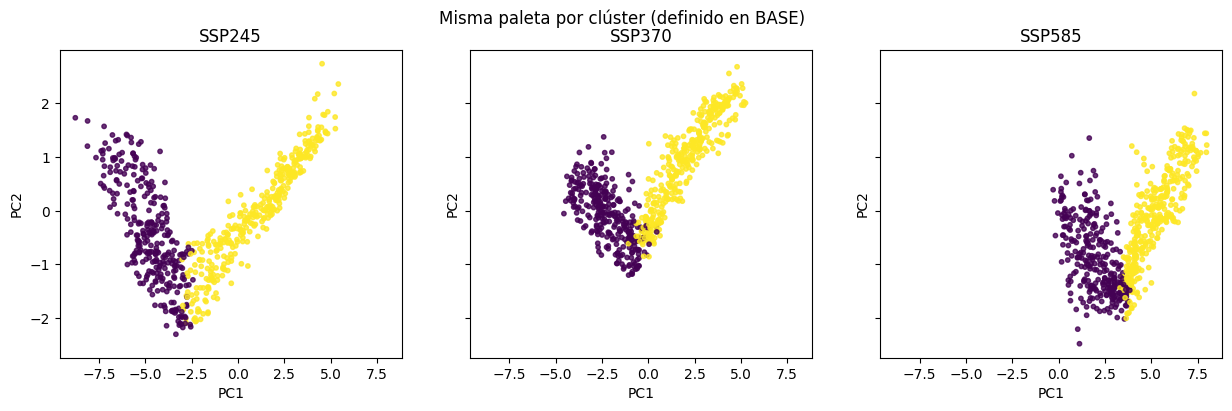

In [44]:
# clúster del baseline para colorear puntos
labels = clB_245
fig, axes = plt.subplots(1, 3, figsize=(15,4), sharex=True, sharey=True)
for ax, Z2d, ttl in zip(axes, [Z245_2d, Z370_2d, Z585_2d], ["SSP245", "SSP370", "SSP585"]):
    sc = ax.scatter(Z2d[:,0], Z2d[:,1], c=labels, s=10, alpha=0.8)
    ax.set_title(ttl); ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
plt.suptitle("Misma paleta por clúster (definido en BASE)")
plt.show()


/tmp/ipykernel_1043458/1107336963.py:8: RuntimeWarning: Mean of empty slice.
  C[j] = Z2d[labels==j].mean(axis=0)
/home/aninotna/.conda/envs/deeplearning/lib/python3.13/site-packages/numpy/_core/_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


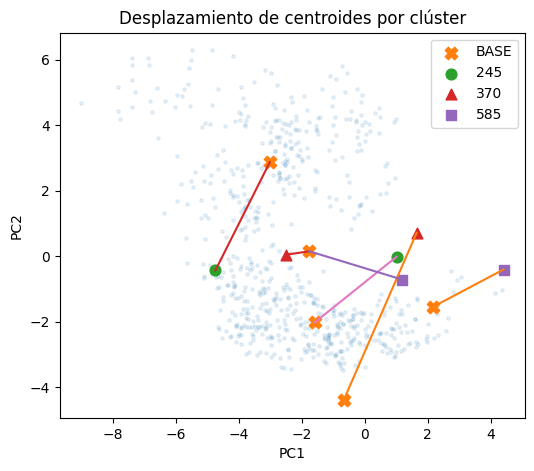

In [45]:
# Centroides en latente (z) y su proyección 2D
cent = km.cluster_centers_
cent2d = pca.transform(cent)

def centroids_for(Z2d, labels, k):
    C = np.zeros((k, 2))
    for j in range(k):
        C[j] = Z2d[labels==j].mean(axis=0)
    return C

C_B = cent2d                                       # centroides del modelo km (baseline)
C_245 = centroids_for(Z245_2d, clB_245, km.n_clusters)
C_370 = centroids_for(Z370_2d, clB_370, km.n_clusters)
C_585 = centroids_for(Z585_2d, clB_585, km.n_clusters)

fig, ax = plt.subplots(figsize=(6,5))
ax.scatter(ZB245_2d[:,0], ZB245_2d[:,1], s=6, alpha=0.1)
ax.scatter(C_B[:,0], C_B[:,1], s=80, marker='X', label="BASE")
ax.scatter(C_245[:,0], C_245[:,1], s=60, marker='o', label="245")
ax.scatter(C_370[:,0], C_370[:,1], s=60, marker='^', label="370")
ax.scatter(C_585[:,0], C_585[:,1], s=60, marker='s', label="585")

for j in range(km.n_clusters):
    ax.plot([C_B[j,0], C_245[j,0]], [C_B[j,1], C_245[j,1]])
    ax.plot([C_B[j,0], C_370[j,0]], [C_B[j,1], C_370[j,1]])
    ax.plot([C_B[j,0], C_585[j,0]], [C_B[j,1], C_585[j,1]])

ax.set_title("Desplazamiento de centroides por clúster")
ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
ax.legend()
plt.show()


In [46]:
import pandas as pd
import numpy as np

# Distancias por píxel y clúster baseline
d245 = np.linalg.norm(z_245 - zB245, axis=1)
d370 = np.linalg.norm(z_370 - zB370, axis=1)
d585 = np.linalg.norm(z_585 - zB585, axis=1)

df = pd.DataFrame({
    "cluster": clB_245,
    "d245": d245, "d370": d370, "d585": d585
}).groupby("cluster").agg(["median","mean","std","count"])

df


d245                                 d370                      \
           median      mean       std count     median      mean       std   
cluster                                                                      
1        4.447498  4.766678  1.628258   303   7.385459   7.42425  0.476810   
2        4.348846  4.174292  1.111412   358  10.344257  10.38905  1.498357   

                   d585                            
        count    median      mean       std count  
cluster                                            
1         303  6.269052  6.442002  0.687388   303  
2         358  6.785099  6.902603  0.768751   358

In [49]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

# Concatenamos en este orden fijo
Z_all = np.vstack([zB245, z_245, z_370, z_585])
sizes = [zB245.shape[0], z_245.shape[0], z_370.shape[0], z_585.shape[0]]
cuts = np.cumsum(sizes)

# Etiquetas por escenario para colorear
scenario_labels = (["BASE_245"]*sizes[0] + 
                   ["SSP245"] *sizes[1] + 
                   ["SSP370"] *sizes[2] + 
                   ["SSP585"] *sizes[3])
scenario_labels = np.array(scenario_labels)

# Ajustar t-SNE (parámetros recomendados para latentes "limpios")
tsne = TSNE(
    n_components=2,
    perplexity=40,          # prueba 30–50 si ves amontonamiento
    learning_rate="auto",
    init="pca",             # arranque estable
    max_iter=1500,
    metric="euclidean",
    random_state=SEED,
    verbose=1
)
Z2_all = tsne.fit_transform(Z_all)

# Separar de vuelta
Z2_B  = Z2_all[:cuts[0]]
Z2_245 = Z2_all[cuts[0]:cuts[1]]
Z2_370 = Z2_all[cuts[1]:cuts[2]]
Z2_585 = Z2_all[cuts[2]:cuts[3]]


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2644 samples in 0.001s...
[t-SNE] Computed neighbors for 2644 samples in 0.051s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2644
[t-SNE] Computed conditional probabilities for sample 2000 / 2644
[t-SNE] Computed conditional probabilities for sample 2644 / 2644
[t-SNE] Mean sigma: 0.666876
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.951973
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.951973
[t-SNE] KL divergence after 1500 iterations: 0.493615
[t-SNE] KL divergence after 1500 iterations: 0.493615


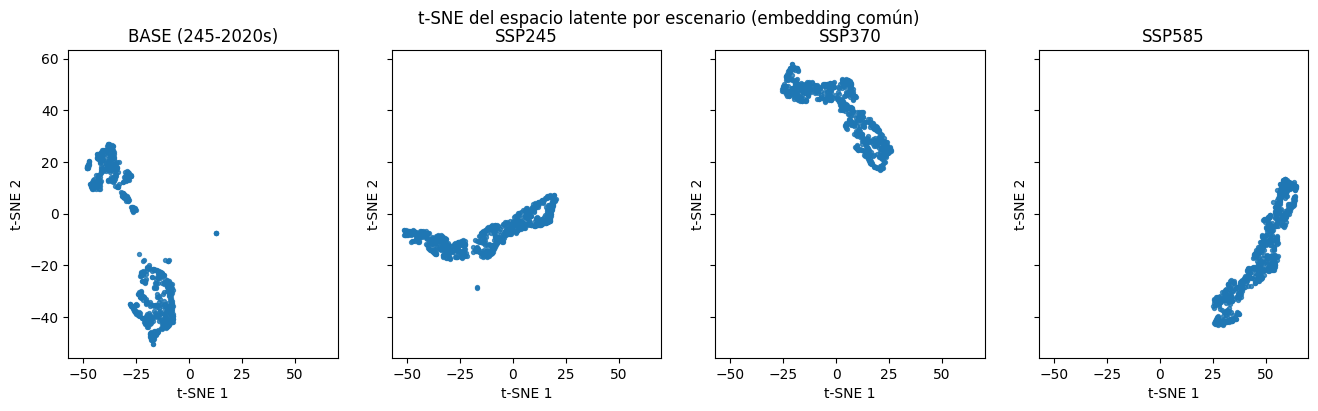

In [50]:
fig, axes = plt.subplots(1, 4, figsize=(16,4), sharex=True, sharey=True)
titles = ["BASE (245-2020s)", "SSP245", "SSP370", "SSP585"]
for ax, Z2, ttl in zip(axes, [Z2_B, Z2_245, Z2_370, Z2_585], titles):
    ax.scatter(Z2[:,0], Z2[:,1], s=8, alpha=0.8)
    ax.set_title(ttl); ax.set_xlabel("t-SNE 1"); ax.set_ylabel("t-SNE 2")
plt.suptitle("t-SNE del espacio latente por escenario (embedding común)")
plt.show()


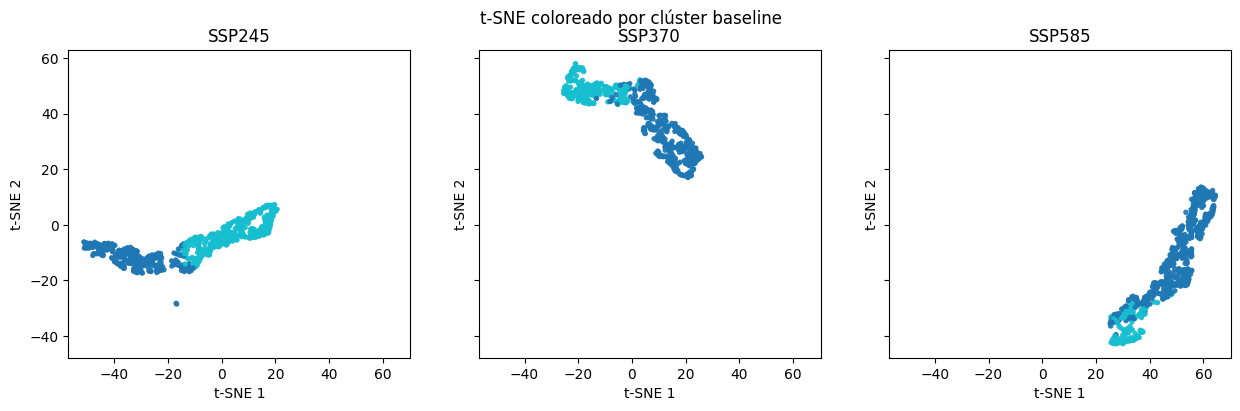

In [51]:
# Repetimos etiquetas de clúster baseline para cada bloque
lab_B = clB_245
lab_245 = clB_245            # comparamos contra su clúster de base por píxel
lab_370 = clB_370            # ya los calculaste
lab_585 = clB_585

fig, axes = plt.subplots(1, 3, figsize=(15,4), sharex=True, sharey=True)
for ax, Z2, labs, ttl in zip(
    axes,
    [Z2_245, Z2_370, Z2_585],
    [lab_245, lab_370, lab_585],
    ["SSP245", "SSP370", "SSP585"]
):
    sc = ax.scatter(Z2[:,0], Z2[:,1], c=labs, s=8, alpha=0.9, cmap="tab10")
    ax.set_title(ttl); ax.set_xlabel("t-SNE 1"); ax.set_ylabel("t-SNE 2")
plt.suptitle("t-SNE coloreado por clúster baseline")
plt.show()


In [52]:
from sklearn.manifold import trustworthiness

tw_B   = trustworthiness(zB245, Z2_B,   n_neighbors=10)
tw_245 = trustworthiness(z_245, Z2_245, n_neighbors=10)
tw_370 = trustworthiness(z_370, Z2_370, n_neighbors=10)
tw_585 = trustworthiness(z_585, Z2_585, n_neighbors=10)
print(f"Trustworthiness (10-NN): BASE={tw_B:.3f} | 245={tw_245:.3f} | 370={tw_370:.3f} | 585={tw_585:.3f}")


Trustworthiness (10-NN): BASE=0.995 | 245=0.995 | 370=0.996 | 585=0.995


In [54]:
# Exportar modelo AE y embeddings para notebook 06
import torch

OUTPUT_DIR = os.path.join(BASE_DIR, "data/autoencoder_trained_v2")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 1. Guardar modelo AE (state_dict)
model_path = os.path.join(OUTPUT_DIR, f"ae_model_latent{LATENT_DIM}_{MODE}.pth")
torch.save(model.state_dict(), model_path)
print(f"✓ Modelo AE guardado en: {model_path}")

# 2. Guardar embeddings (latents) en formato .npz
latents_path = os.path.join(OUTPUT_DIR, f"ae_latents_{MODE}.npz")
np.savez_compressed(
    latents_path,
    # Baseline por SSP
    zB245=zB245, zB370=zB370, zB585=zB585,
    # Target por SSP
    z_245=z_245, z_370=z_370, z_585=z_585,
    # Clusters baseline
    clB_245=clB_245, clB_370=clB_370, clB_585=clB_585,
    # Clusters target
    cl_245=cl_245, cl_370=cl_370, cl_585=cl_585,
    # Metadata del clustering
    n_clusters=km.n_clusters,
    cluster_centers=km.cluster_centers_
)
print(f"✓ Embeddings AE guardados en: {latents_path}")

# 3. Guardar métricas de resiliencia calculadas
metrics_path = os.path.join(OUTPUT_DIR, f"ae_metrics_{MODE}.npz")
np.savez_compressed(
    metrics_path,
    # Distancias
    dist_245=dist_245, dist_370=dist_370, dist_585=dist_585,
    # Estabilidad de clusters
    stab_245=stab_245, stab_370=stab_370, stab_585=stab_585,
    # Índices de resiliencia
    R_245=R_245, R_370=R_370, R_585=R_585
)
print(f"✓ Métricas AE guardadas en: {metrics_path}")

print(f"\nArchivos exportados para consumo en notebook 06:")
print(f"  - Modelo: {os.path.basename(model_path)}")
print(f"  - Embeddings: {os.path.basename(latents_path)}")
print(f"  - Métricas: {os.path.basename(metrics_path)}")

✓ Modelo AE guardado en: /home/aninotna/magister/tesis/justh2_pipeline/data/autoencoder_trained_v2/ae_model_latent8_test.pth
✓ Embeddings AE guardados en: /home/aninotna/magister/tesis/justh2_pipeline/data/autoencoder_trained_v2/ae_latents_test.npz
✓ Métricas AE guardadas en: /home/aninotna/magister/tesis/justh2_pipeline/data/autoencoder_trained_v2/ae_metrics_test.npz

Archivos exportados para consumo en notebook 06:
  - Modelo: ae_model_latent8_test.pth
  - Embeddings: ae_latents_test.npz
  - Métricas: ae_metrics_test.npz
